In [37]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from textblob import TextBlob
import snscrape.modules.twitter as snstwitter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
plt.style.use('ggplot')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/veraachiaa/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/veraachiaa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/veraachiaa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Collection of Data

In [23]:
def collect_data():
    location = '4.4149, -3.0424, 680km'
    query = '("elevy" OR "e-levy" OR "increase OR VAT" OR "Financial OR sector OR levy" OR "income OR tax OR bill" OR "covid OR levy" OR "sustainability OR levy" OR "addo OR levy" OR "covid OR tax" OR "betting OR tax" OR "exercise OR duty OR bill" OR "electronic OR levy") until:2023-06-20 since:2020-03-01 geocode:"{}"'.format(location)

    tweets = []
    limit = 200000


    for tweet in snstwitter.TwitterSearchScraper(query).get_items():

        # print(vars(tweet))
        # break
        if len(tweets) == limit:
            break
        else:
            tweets.append([tweet.date, tweet.user.username, tweet.rawContent])

    df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])
    print(df)

    # Save tweets to CSV
    df.to_csv('tweets.csv')

    return df

In [ ]:
# Call collect_data function
df = collect_data()

In [30]:
df.head()

,Unnamed: 0,Date,User,Tweet
0,0,2023-06-03 15:08:40+00:00,mrbones_evans,@hon_adutette @KwakubaK @SethTerkper @YouthAll...
1,1,2023-05-29 13:13:51+00:00,Walkinonlinekms,It’s lunch time and we’re serving. SetGh370. S...
2,2,2023-05-28 23:58:48+00:00,oheek1,@NAkufoAddo we are expecting you to also aboli...
3,3,2023-05-28 13:07:18+00:00,DManortey,Sanitary pad is a basic necessity even. Why im...
4,4,2023-05-28 13:05:57+00:00,IssahakuHuzaif1,Sanitary pad is a basic necessity even. Why im...


## Preprocessing of Tweet

In [39]:
df = pd.read_csv("tweets.csv")

In [40]:
def clean_text(tweet_text):
    # Remove mentions
    mention_pattern = re.compile(r'@\w+')
    tweet_text = re.sub(mention_pattern, '', tweet_text)

    # Remove Hashtags
    tweet_text = re.sub(r'#', '', tweet_text)

    # Remove retweets
    tweet_text = re.sub(r'RT[\s]+', '', tweet_text)

    # Remove urls
    tweet_text = re.sub(r'https?:\/\/\S+', '', tweet_text)

    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002600-\U000027BF"  # miscellaneous symbols
                               u"\U0001F910-\U0001F9FF"  # faces with accessories
                               u"\u200d"  # zero-width joiner
                               u"\u2600-\u26FF\u2700-\u27BF"  # additional symbols
                               u"\u3000-\u303F"  # punctuation symbols
                               u"\uFE0F"  # emoji variation selector
                               "]+", flags=re.UNICODE)
    tweet_text = re.sub(emoji_pattern, '', tweet_text)

    # Remove newlines
    newline_pattern = re.compile(r'\n')
    tweet_text = re.sub(newline_pattern, '', tweet_text)

    # Remove stopwords
    tokens = word_tokenize(tweet_text)

    # Get the list of stopwords
    stop_words = set(stopwords.words('english'))

    # Remove stopwords from the tokens
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

    # Join the filtered tokens back into a single string
    filtered_tweet = ' '.join(filtered_tokens)

    return filtered_tweet


df['Tweet'] = df['Tweet'].apply(clean_text)


## Sentiment Analysis using Textblob

In [ ]:
df.head()

In [41]:
# Read Data
# df = pd.read_csv('cleaned_tweet_2.csv')

tweets = df['Tweet']

In [42]:
sentiments = []
for tweet in tweets:
    blob = TextBlob(str(tweet))
    polarity = blob.sentiment.polarity
    if polarity > 0:
        sentiment = 'Positive'
    elif polarity < 0:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'
    sentiments.append(sentiment)

# Add the sentiments to the DataFrame
df['Sentiment'] = sentiments

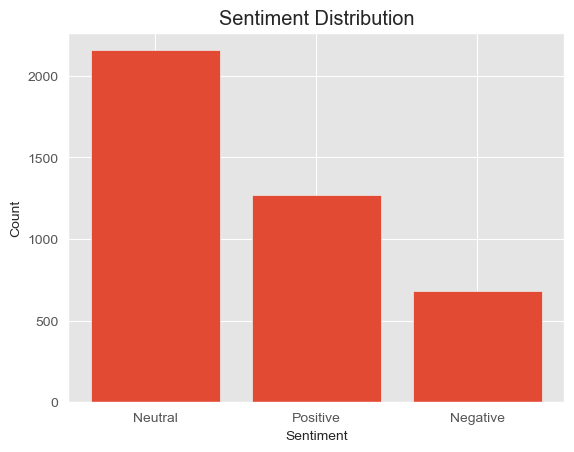

In [43]:
# Plot the sentiment distribution
sentiment_counts = df['Sentiment'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.savefig('plot.png')
plt.show()

## Sentiment Analysis using Vader(NLTK)

In [51]:
vaders_df = df.drop('Sentiment', axis=1)

In [50]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm


sia = SentimentIntensityAnalyzer()

In [52]:
# Run polarity score on entire dataframe
result = {}
for i, row  in tqdm(vaders_df.iterrows(), total=len(df)):
    tweet = row['Tweet']
    myid = row['User']
    result[myid] = sia.polarity_scores(tweet)

  0%|          | 0/4103 [00:00<?, ?it/s]

In [47]:
# Store Vaders result in dataframe and merge with main dataframe
vaders_res = pd.DataFrame(result).T
vaders_res = vaders_res.reset_index().rename(columns={'index': 'User'})
vaders_df = vaders_res.merge(vaders_df, how='left')

In [49]:
# Sentiment score and metadata
vaders_df.head()

,User,neg,neu,pos,compound,Unnamed: 0,Date,Tweet
0,mrbones_evans,0.0,1.000,0.000,0.0000,0,2023-06-03 15:08:40+00:00,means 1.5 % e-levy ’ took 12 months get gh74b ...
1,Walkinonlinekms,0.0,0.892,0.108,0.3182,1,2023-05-29 13:13:51+00:00,’ lunch time ’ serving . SetGh370 . day delive...
2,Walkinonlinekms,0.0,0.892,0.108,0.3182,8,2023-05-20 15:17:56+00:00,ordered yet . Gh300 . Order today get today . ...
3,Walkinonlinekms,0.0,0.892,0.108,0.3182,11,2023-05-20 12:04:43+00:00,Keep orders coming . Set : Gh460 . Order today...
4,Walkinonlinekms,0.0,0.892,0.108,0.3182,12,2023-05-20 09:19:51+00:00,Good morning . ’ open . Keep orders coming . d...


In [28]:
# pos_counts = vaders_df['pos'].value_counts()
# sns.barplot(data=vaders_df, x='pos', y=pos_counts)

## Sentiment Analysis using Roberta

In [ ]:
roberta_df = df.drop('Sentiment', axis=1)
roberta_df.head()

In [53]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [54]:
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [55]:
# Get Polarity Scores using Roberta
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [56]:
roberta_res = {}
try:
    for i, row  in tqdm(df.iterrows(), total=len(df)):
        tweet = row['Tweet']
        myid = row['User']
        vader_result = sia.polarity_scores(tweet)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value

        roberta_result = polarity_scores_roberta(tweet)
        both = {**vader_result, **roberta_result}
        roberta_res[myid] = both
except RuntimeError:
    print(f'Broke for username: {myid}')

  0%|          | 0/4103 [00:00<?, ?it/s]

In [58]:
results_df = pd.DataFrame(result).T
results_df = results_df.reset_index().rename(columns={'index': 'User'})
results_df = results_df.merge(vaders_df, how='left')

In [59]:
results_df.head()

,User,neg,neu,pos,compound,Unnamed: 0,Date,Tweet
0,mrbones_evans,0.0,1.000,0.000,0.0000,0,2023-06-03 15:08:40+00:00,means 1.5 % e-levy ’ took 12 months get gh74b ...
1,Walkinonlinekms,0.0,0.892,0.108,0.3182,1,2023-05-29 13:13:51+00:00,’ lunch time ’ serving . SetGh370 . day delive...
2,Walkinonlinekms,0.0,0.892,0.108,0.3182,8,2023-05-20 15:17:56+00:00,ordered yet . Gh300 . Order today get today . ...
3,Walkinonlinekms,0.0,0.892,0.108,0.3182,11,2023-05-20 12:04:43+00:00,Keep orders coming . Set : Gh460 . Order today...
4,Walkinonlinekms,0.0,0.892,0.108,0.3182,12,2023-05-20 09:19:51+00:00,Good morning . ’ open . Keep orders coming . d...


## Compare Score betweeen models

In [ ]:
sns.pairplot(data=results_df, vars = ['neg', 'neu', 'pos', 'roberta_neg', 'roberta_neu',
                                      'roberta_pos'])
plt.savefig('plot_2.png')
plt.show()